In [32]:
import numpy as np
import pandas as pd
import os
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor as rfr
import matplotlib.pyplot as plt



In [ ]:
# Read in data

In [12]:
# Filter and visualise the data
file_name = 'cah2_extracted_chembl_data_ours.csv'
df = pd.read_csv(os.path.join('data',file_name))



In [26]:
from rdkit import Chem

mols = {}
for chembl_id, row in df.iterrows():
    mols[chembl_id] = Chem.MolFromSmiles(row['canonical_smiles'])

    

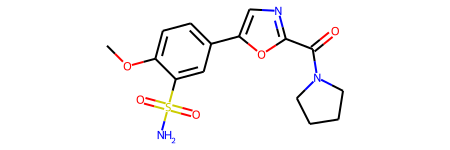

In [27]:
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors

mols[0]

In [28]:
descriptors = {}

descriptors['n_atoms'] = {chembl_id: Descriptors.HeavyAtomCount(mol) for chembl_id, mol in mols.items()}
descriptors['rotatable_bonds'] = {chembl_id: Descriptors.NumRotatableBonds(mol) for chembl_id, mol in mols.items()}
descriptors['logp'] = {chembl_id: Descriptors.MolLogP(mol) for chembl_id, mol in mols.items()}
descriptors['molecular_weight'] = {chembl_id: Descriptors.ExactMolWt(mol) for chembl_id, mol in mols.items()}
descriptors['hb_donors'] = {chembl_id: Descriptors.NumHDonors(mol) for chembl_id, mol in mols.items()}
descriptors['hb_acceptors'] = {chembl_id: Descriptors.NumHAcceptors(mol) for chembl_id, mol in mols.items()}

descriptors = pd.DataFrame.from_dict(descriptors)

descriptors

,n_atoms,rotatable_bonds,logp,molecular_weight,hb_donors,hb_acceptors
0,24,4,1.23360,351.088892,1,6
1,23,3,1.53342,335.093977,1,5
2,15,2,1.35892,243.997634,1,5
3,18,3,2.31800,284.028934,1,5
4,21,3,1.28650,327.034748,1,6
...,...,...,...,...,...,...
5287,13,7,-1.26310,194.128274,0,2
5288,42,15,4.94284,736.044692,2,4
5289,5,0,-1.25210,96.983364,2,2
5290,23,6,2.05762,333.103479,1,4


In [36]:
ligand_efficiency = df['pchembl_value'] / descriptors.loc[df.index]['n_atoms']

fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.scatter(descriptors.loc[df.index]['n_atoms'], ligand_efficiency, alpha=0.5)
ax.set_xlabel('Number of heavy atoms')
ax.set_ylabel('pK/heavy atom')
plt.close()

,n_atoms,rotatable_bonds,logp,molecular_weight,hb_donors,hb_acceptors
1798,191,154,-0.5970,2875.222704,8,63
3010,171,148,-2.1986,2565.214505,6,59
4731,173,148,0.0984,2549.320668,6,53


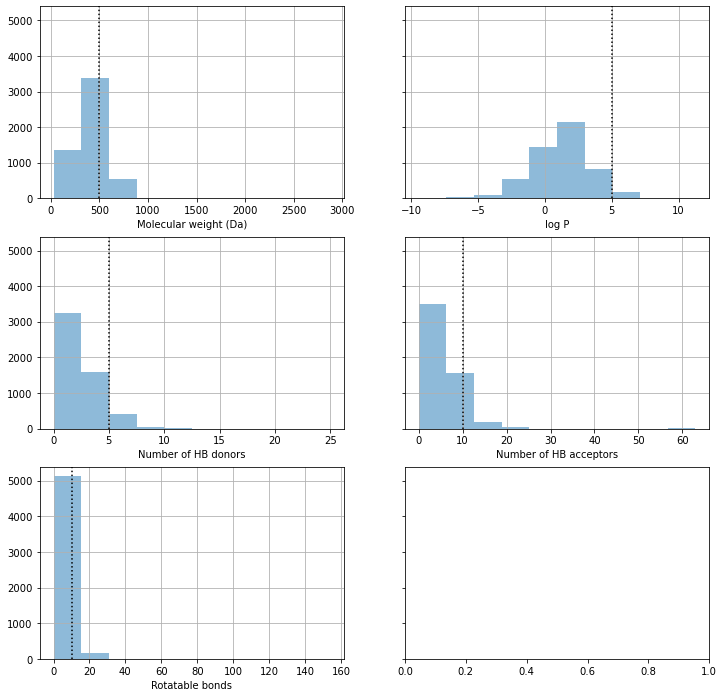

In [43]:
fig, axes = plt.subplots(3,2,figsize=(12,12), sharey=True)
axes = axes.flat
descriptors['molecular_weight'].hist(ax=axes[0], alpha=0.5)
axes[0].axvline(500, color='k', linestyle=':')
axes[0].set_xlabel('Molecular weight (Da)')
descriptors['logp'].hist(ax=axes[1], alpha=0.5)
axes[1].set_xlabel('log P')
axes[1].axvline(5, color='k', linestyle=':')
descriptors['hb_donors'].hist(ax=axes[2], alpha=0.5)
axes[2].set_xlabel('Number of HB donors')
axes[2].axvline(5, color='k', linestyle=':')
descriptors['hb_acceptors'].hist(ax=axes[3], alpha=0.5)
axes[3].set_xlabel('Number of HB acceptors')
axes[3].axvline(10, color='k', linestyle=':')
descriptors['rotatable_bonds'].hist(ax=axes[4], alpha=0.5)
axes[4].set_xlabel('Rotatable bonds')
axes[4].axvline(10, color='k', linestyle=':')

outlier = descriptors.loc[descriptors['rotatable_bonds'] > 60]
outlier.head(10)
#outlier['rotatable_bonds'].hist(ax=axes[5], alpha=0.5)
#axes[5].set_xlabel('Rotatable bonds outlier')
#axes[5].axvline(10, color='k', linestyle=':')
#plt.close();

In [48]:
X = descriptors.to_numpy()
y = df['pchembl_value'].to_numpy()
#print(X,y,y.shape[0], sep='\n\n\n\n')


[[ 24.           4.           1.2336     351.08889164   1.
    6.        ]
 [ 23.           3.           1.53342    335.09397702   1.
    5.        ]
 [ 15.           2.           1.35892    243.99763412   1.
    5.        ]
 ...
 [  5.           0.          -1.2521      96.98336396   2.
    2.        ]
 [ 23.           6.           2.05762    333.10347909   1.
    4.        ]
 [  8.           2.          -3.2136     124.05002381   0.
    2.        ]]



[11.   11.   11.   ...  4.01  4.01  4.  ]



5292


In [ ]:
# Split the data (randomly) into train, val and test
X_train, X_test, y_train, y_test 
    = train_test_split(X, y, test_size=0.1, random_state=1)

 X_train, X_val, y_train, y_val 
    = train_test_split(X_train, y_train, test_size=1/9, random_state=1) # (1/9) x 0.9 = 0.1
    

In [57]:
sc = preprocessing.StandardScaler()
sc.fit(X)
sc.transform(X)

ValueError: Expected 2D array, got 1D array instead:
array=[11.   11.   11.   ...  4.01  4.01  4.  ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
# Scale the data

scaler = preprocessing.MinMaxScaler() # preprocessing.StandardScaler

X_train_scaled = scaler.fit_transform(X_train)
y_train_scaled = scaler.fit_transform(y_train)

In [ ]:
# Fitting using chosen method
n_estimators = 10
model = rfr(n_estimators)
# Train
model.fit(X_train_scaled, y_train_scaled)

In [ ]:
# Visualising rfr results
# Extract single tree
estimator = model.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = df.columns,
                class_names = 'pChembl',
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')